In [1]:
!pip install scikit-learn
!pip install torchvision

In [1]:
import torch
import torchvision
import warnings
from torchvision import transforms

In [2]:
transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              transforms.Lambda(lambda x: torch.flatten(x))])

data_set = torchvision.datasets.FashionMNIST('./files/fashion-mnist/', train=True, download=True,
                             transform=transformer)
batch_size=len(data_set)//5

In [3]:
loader = torch.utils.data.DataLoader(
  data_set,
  batch_size=batch_size, shuffle=True)

train = enumerate(loader)
_, (data, targets) = next(train)

In [4]:
from sklearn.model_selection import cross_val_score

## KNN

In [5]:
from sklearn.neighbors import KNeighborsClassifier

Testing knn for different k

In [5]:
ks = [i+1 for i in range(15)]
scores = []

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    
    with warnings.catch_warnings(record=True):
        score = cross_val_score(
            knn,
            data,
            targets, 
            cv=5
        )
    scores.append(score.mean())
max(scores)

0.8285833333333332

We get around 82.8% accuracy. Because KNN is the simplest algorithm this will be the baseline accuracy which we will try to improve.

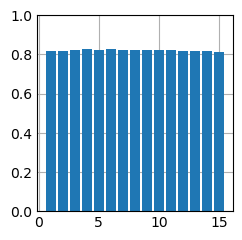

In [6]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('_mpl-gallery')

# plot
fig, ax = plt.subplots()

ax.bar(ks, scores)

ax.set(ylim=(0, 1))

plt.show()

As we can see on the graph, the highest accuracy score is observed for k = 4 or k = 6 on this data.

Some tests of other algorithms:

## Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,f1_score

Logistic regression with L2 penalty regularization and lbfgs solver algorithm:

In [10]:
lr = LogisticRegression(warm_start=True, max_iter = 200, random_state=0, n_jobs=-1)
score = cross_val_score(
    lr,
    data,
    targets, 
    cv=5
)
score.mean()

0.8355

It beats knn score out of the box.

Different solvers:

In [ ]:
# def classification_report_with_accuracy_score(y_true, y_pred):
#     print classification_report(y_true, y_pred) # print classification report
#     return accuracy_score(y_true, y_pred) # return accuracy score

# nested_score = cross_val_score(lr, data, targets, cv=5, \
#                scoring=make_scorer(classification_report_with_accuracy_score))
# print nested_score 

# lr.fit(data, targets)
# lr_pred = lr.predict(targets)

# classification_report(test_y, lr_pred, labels=range(0,10))

Testing with newton-cholesky solver:

In [7]:
lr = LogisticRegression(warm_start=True, solver='newton-cholesky', max_iter = 200, random_state=0, n_jobs=-1)
score = cross_val_score(
    lr,
    data,
    targets, 
    cv=5
)
score.mean()

0.8353333333333335

Testing with SAGA solver and elasticnet penalties:

In [12]:
lr = LogisticRegression(solver='saga', n_jobs=-1)
score = cross_val_score(
    lr,
    data,
    targets, 
    cv=5
)
score.mean()

0.8408333333333333

## Logistic regression with bagging and boosting

In [13]:
from sklearn.ensemble import BaggingClassifier

In [16]:
bg = BaggingClassifier(estimator=LogisticRegression(solver='saga', n_jobs=-1), n_estimators=10, random_state=0, n_jobs=-1)
score = cross_val_score(
    bg,
    data,
    targets, 
    cv=3
)
score.mean()

0.8396666666666667

Testing with bootstrap features. On theory this will make some feature selection.

In [25]:
bg = BaggingClassifier(estimator=LogisticRegression(solver='saga', n_jobs=-1), n_estimators=10, random_state=0, n_jobs=-1, bootstrap_features= True)
score = cross_val_score(
    bg,
    data,
    targets, 
    cv=3
)
score.mean()

0.842

In [15]:
from sklearn.ensemble import AdaBoostClassifier

In [18]:
ab = AdaBoostClassifier(estimator=LogisticRegression(solver='saga', n_jobs=-1), n_estimators=10, random_state=0)
score = cross_val_score(
    bg,
    data,
    targets, 
    cv=3
)
score.mean()

0.8396666666666667

As we can see there is no improvement.
We will try to preprocess the data.

In [19]:
from sklearn.preprocessing import RobustScaler

The robust scaler scales the data according to the quantile range. It is usefull for data with many outliers

In [20]:
transformer = RobustScaler().fit(data)
transformed_data = transformer.transform(data)

In [22]:
lr = LogisticRegression(solver='saga', n_jobs=-1)
score = cross_val_score(
    lr,
    transformed_data,
    targets, 
    cv=5
)
score.mean()

0.8007500000000001

But the results show that there is no improvement.